In [1]:
import requests as r
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
from collections import Counter
import pymorphy2
import time
import matplotlib.pyplot as plt

### Собираем корпус слов

In [2]:
corpus = Counter()
morph = pymorphy2.MorphAnalyzer()

for i in tqdm(range(360)):
    soup = BeautifulSoup(r.get(f'https://ilibrary.ru/text/11/p.{i+1}/index.html').text, 'html.parser')  # soup
    el = [el.text.rstrip().lower() for el in soup.find_all('span', class_='p')]  # text
    words = re.findall('[а-яА-Я]+', ' '.join(el))  # only russian
    tmp = list()
    for w in words:
        w = morph.parse(w)[0].normal_form
        if len(w) != 5:
            continue
        tmp.append(w)
    
    words = tmp
    c = Counter(words)
    
    corpus.update(c)
    time.sleep(.5)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [05:31<00:00,  1.09it/s]


### Отбираем по уже прошедшим правилам

In [3]:
def rule1(l: str, word: str, pos: int) -> bool:  # Угадали и букву и место (True - стоп, False - дальше)
    return l != word[pos-1] or (l in word and word[pos-1] != l)

def rule2(l: str, word: str, pos: int) -> bool:  # Угадали букву, но не место
    return l not in word or word[pos-1] == l

def rule3(l: str, word: str) -> bool:  # Не угадали букву
    return l in word

In [9]:
rules = [
#     lambda word: rule3('в', word),
#     lambda word: rule3('р', word),
#     lambda word: rule3('е', word),
#     lambda word: rule2('м', word, 4),
#     lambda word: rule3('я', word),
]

res = dict()
for word, freq in tqdm(corpus.items()):
    f = True
    for rule in rules:
        if rule(word):
            f = False
            break
    if not f:
        continue
    
    res[word] = freq

res = Counter(res)

100%|█████████████████████████████████████████████████████████████████████████| 1405/1405 [00:00<00:00, 1811000.96it/s]


### Самые вероятные слова

In [10]:
print(sum(res.values()), 'слов из', sum(corpus.values()))

45711 слов из 45711


In [11]:
res.most_common(50)

[('князь', 2057),
 ('знать', 1346),
 ('когда', 1143),
 ('чтобы', 968),
 ('время', 965),
 ('такой', 875),
 ('какой', 782),
 ('марья', 759),
 ('слово', 686),
 ('стать', 674),
 ('жизнь', 632),
 ('опять', 620),
 ('голос', 594),
 ('очень', 556),
 ('после', 544),
 ('иметь', 514),
 ('вдруг', 501),
 ('самый', 500),
 ('ежели', 483),
 ('будто', 481),
 ('армия', 480),
 ('взять', 442),
 ('выйти', 440),
 ('более', 429),
 ('перед', 428),
 ('место', 402),
 ('дверь', 374),
 ('новый', 373),
 ('пойти', 371),
 ('между', 365),
 ('ехать', 350),
 ('никто', 336),
 ('мысль', 327),
 ('через', 321),
 ('войти', 305),
 ('потом', 304),
 ('борис', 297),
 ('война', 293),
 ('народ', 291),
 ('тогда', 277),
 ('нужно', 265),
 ('назад', 262),
 ('толпа', 260),
 ('немой', 250),
 ('общий', 219),
 ('можно', 214),
 ('долох', 204),
 ('кроме', 200),
 ('много', 200),
 ('вечер', 196)]

### Вероятности по буквам

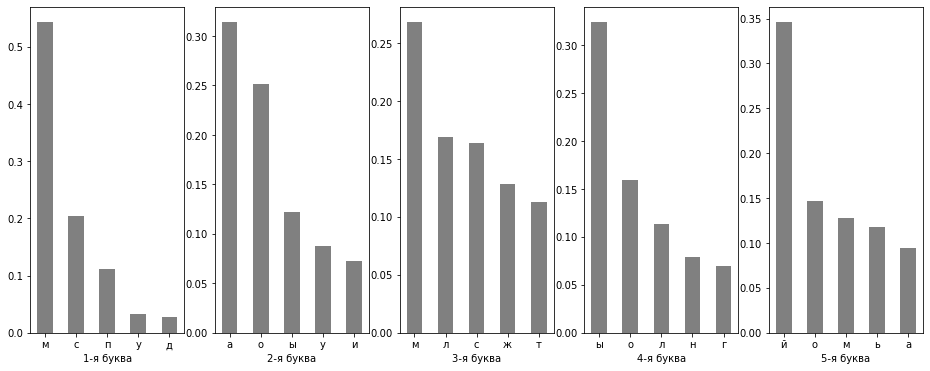

In [8]:
n = 5  # Будем рысовать по 5 букв на позицию

fig, ax = plt.subplots(1, 5, figsize=(16, 6))

for pos in range(5):
    # Посчитали буквы на позиции
    tmp = Counter()
    for word, freq in res.items():
        l = word[pos]
        tmp.update(Counter({l: freq}))
    
    # Берем n самых популярных и считаем вероятности
    tmp1 = dict()
    for l, freq in tmp.most_common(n):
        tmp1[l] = round(freq / sum(tmp.values()), 3)
    
    ax[pos].set_xlabel(f'{pos+1}-я буква')
    ax[pos].bar(list(tmp1.keys()), list(tmp1.values()), color='gray', width=.5)
    
    
plt.show()